In [1]:
import random
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import euclidean
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

## 2. Algorithms

We implement the algorithms in a relatively lightweight manner:

### Perceptron

In [2]:
class Perceptron:
    def __init__(self, dim):
        self.w = np.zeros(dim)
        
    def update(self, x, y):
        y_pred = self.predict(x)
        if y*y_pred <= 0:
            self.w += y*x
        
    def predict(self, X):
        y_pred = np.sign(np.dot(X, self.w))
        return np.where(y_pred >= 0.0, 1, -1) 

### Winnow

In [3]:
class Winnow:
    def __init__(self, dim):
        self.w = np.ones(dim)
        self.dim = dim
    
    def update(self, x, y):
        y_pred = self.predict(x)[0]
        if y != y_pred:
            self.w = self.w*(2**((y - y_pred)*x))
            
    def predict(self, X):
        y_pred = np.zeros(X.shape[0])
        pos_ix = (np.dot(X, self.w) >= self.dim)
        y_pred[pos_ix] = 1
        return y_pred

### Least Squares

In [4]:
def least_squares(X, y, X_test):
    # train
    coeffs = np.linalg.pinv(X.T.dot(X)).dot(X.T).dot(y)

    # test
    y_preds = np.sign(X_test.dot(coeffs))
    
    return y_preds

### 1-NN

In [22]:
from scipy.spatial.distance import cdist

def nn(X, y, X_test):
    distances = cdist(X_test, X, metric='sqeuclidean')
    y_preds = y[np.argmin(distances, axis=1)]
    
    return y_preds

## Utilities

In [6]:
def ind(y, y_prime):
    return (y != y_prime).sum()

def generate_data_quicker(m, n, winnow=False):
    a = np.random.rand(m, n)
    a[a >= 0.5] = 1
    a[a < 0.5] = -1
    X = a
    if winnow:
        X[X == -1] = 0
    return X, X[:, 0]

def calc_err_online(model, X):
    k = ind(model.predict(X), X[:, 0])
    return k/X.shape[0]

def calc_err(A,  S_m, X):
    k = ind(A(S_m, S_m[:, 0], X), X[:, 0])
    return k/X.shape[0]

In [7]:
# for stateful (i.e. online) models
def estimate_sample_complexity_online(model_class, n_max, epochs=30, delta=0, V_size=1000):
    winnow = (model_class == Winnow)
    n_to_m_samples = {i: [] for i in range(2, n_max)}
    for n in tqdm(list(range(2, n_max))):
        for epoch in range(epochs):
            X_val, y_val = generate_data_quicker(V_size, n, winnow)
            X_train, y_train = generate_data_quicker(2000, n, winnow)
            model = model_class(n)
            for m in range(1, 2**n):
                model.update(X_train[m, :], y_train[m])
                err = calc_err_online(model, X_val)
                if err <= 0.1 - delta:
                    n_to_m_samples[n].append(m)
                    break
    return n_to_m_samples

# for non-stateful (i.e. offline) models
def estimate_sample_complexity(A, n_max, epochs=30, delta=0, V_size=1000):
    n_to_m_samples = {i: [] for i in range(2, n_max)}
    for n in tqdm(list(range(2, n_max))):
        for epoch in range(epochs):
            X_val, y_val = generate_data_quicker(V_size, n)
            X_train, y_train = generate_data_quicker(2000, n)
            for m in range(1, 2**n):
                err = calc_err(A, X_train[:m, :], X_val)
                if err <= 0.1 - delta:
                    n_to_m_samples[n].append(m)
                    break
    return n_to_m_samples
    
    
def results_to_df(results_dict):
    results = {n: (np.mean(ms), np.std(ms)) for n, ms in results_dict.items()}
    return pd.DataFrame(results, index=['mean', 'std'], columns=results.keys()).T

## Estimating and Graphing Sample Complexity

Let's use our functions to create graphs of the sample complexity

100%|██████████| 98/98 [00:33<00:00,  1.50it/s]


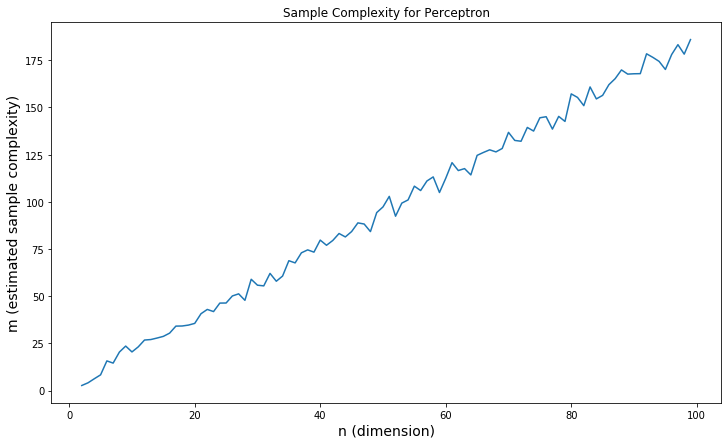

In [8]:
result_perceptron = estimate_sample_complexity_online(Perceptron, 100, epochs=50)
df_results_perceptron = results_to_df(result_perceptron)
plt.figure(figsize=(12,7), )
plt.plot(df_results_perceptron['mean'])
plt.title('Sample Complexity for Perceptron')
plt.xlabel('n (dimension)', fontsize=14)
plt.ylabel('m (estimated sample complexity)', fontsize=14);

100%|██████████| 98/98 [02:02<00:00,  4.06s/it]


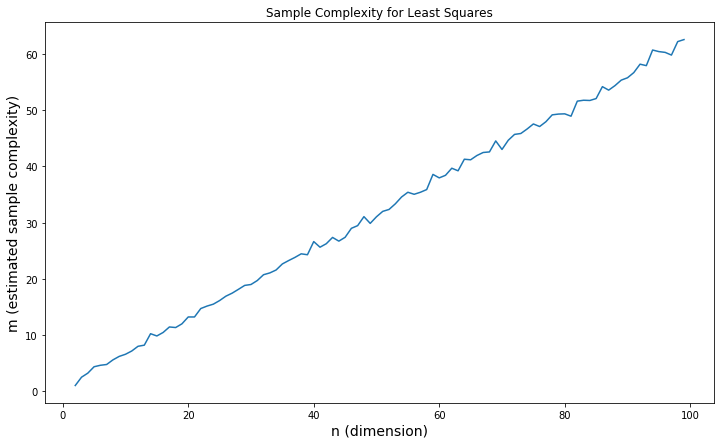

In [9]:
result_least_squares = estimate_sample_complexity(least_squares, 100, epochs=50)
df_results_least_squares = results_to_df(result_least_squares)
plt.figure(figsize=(12,7))
plt.plot(df_results_least_squares['mean'])
plt.title('Sample Complexity for Least Squares')
plt.xlabel('n (dimension)', fontsize=14)
plt.ylabel('m (estimated sample complexity)', fontsize=14);

100%|██████████| 98/98 [00:25<00:00,  2.17it/s]


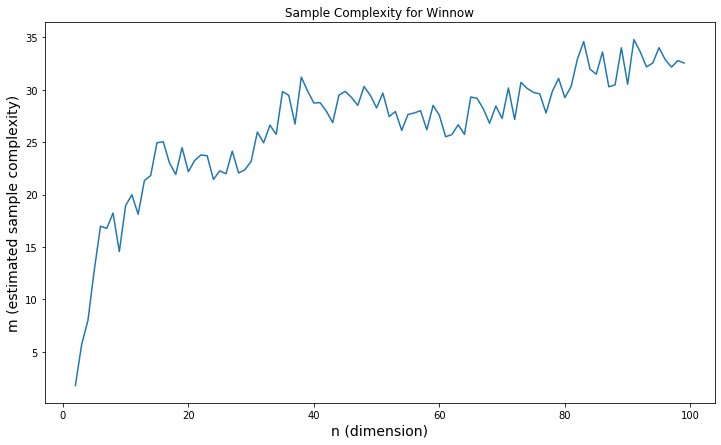

In [10]:
result_winnow = estimate_sample_complexity_online(Winnow, 100, epochs=50)
df_results_winnow = results_to_df(result_winnow)
plt.figure(figsize=(12,7))
plt.plot(df_results_winnow['mean'])
plt.title('Sample Complexity for Winnow')
plt.xlabel('n (dimension)', fontsize=14)
plt.ylabel('m (estimated sample complexity)', fontsize=14);








  0%|          | 0/16 [00:00<?, ?it/s]






 25%|██▌       | 4/16 [00:00<00:00, 36.06it/s]






 38%|███▊      | 6/16 [00:00<00:00, 19.27it/s]






 50%|█████     | 8/16 [00:01<00:01,  5.66it/s]






 56%|█████▋    | 9/16 [00:02<00:03,  1.94it/s]






 62%|██████▎   | 10/16 [00:04<00:05,  1.03it/s]






 69%|██████▉   | 11/16 [00:09<00:10,  2.10s/it]






 75%|███████▌  | 12/16 [00:29<00:29,  7.48s/it]






 81%|████████▏ | 13/16 [01:43<01:22, 27.41s/it]






 88%|████████▊ | 14/16 [13:19<07:36, 228.00s/it]






 94%|█████████▍| 15/16 [37:19<09:51, 591.58s/it]






100%|██████████| 16/16 [2:20:23<00:00, 2269.51s/it]








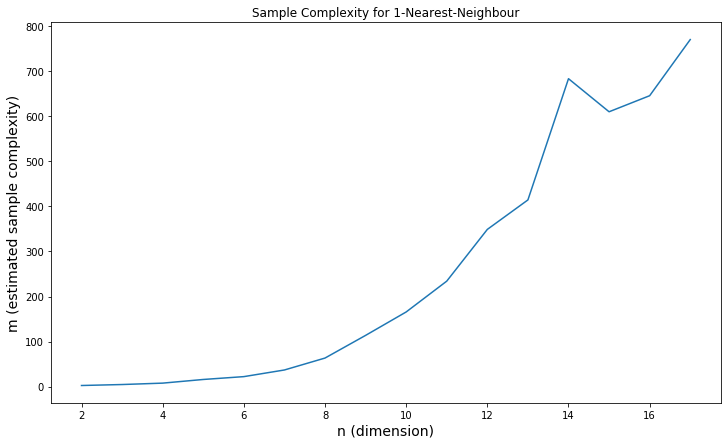

In [23]:
result_nn = estimate_sample_complexity(nn, 18, epochs=50, V_size=100)
df_results_nn = results_to_df(result_nn)
plt.figure(figsize=(12,7))
plt.plot(df_results_nn['mean'])
plt.title('Sample Complexity for 1-Nearest-Neighbour')
plt.xlabel('n (dimension)', fontsize=14)
plt.ylabel('m (estimated sample complexity)', fontsize=14);